# PD6 - Adam Frej

## Import paczek i danych:

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as rmse
import copy

In [2]:
oliv_df = fetch_olivetti_faces()
oliv_df = oliv_df['images']

## Rysowanie wybranych obrazków:

In [3]:
def draw_20(x):
    fig = plt.figure()
    fig, axs = plt.subplots(4, 5)
    fig.set_figheight(10)
    fig.set_figwidth(16)
    axs = axs.ravel()
    for i in range(0,20):
        axs[i].imshow(x[i], cmap='gray')
        axs[i].axis("off")
    plt.show()

<Figure size 432x288 with 0 Axes>

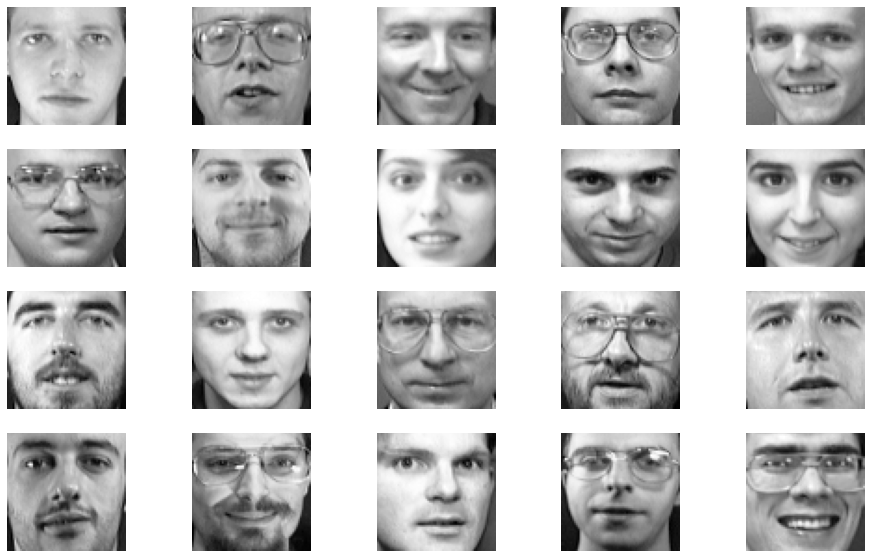

In [4]:
x = oliv_df
x = x[[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190], :]
draw_20(x)

## Algorytm PCA:

Najpierw zastosujmy algorytm na automatycznej liczbie komponentów, aby narysować wykres wariancji.

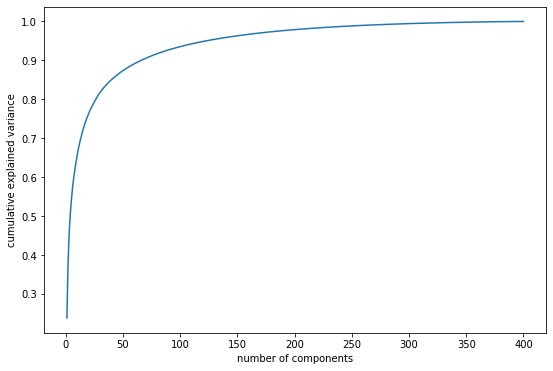

In [5]:
oliv_df_pca = np.reshape(oliv_df, (400, 4096))
pca = PCA()
pca.fit(oliv_df_pca)
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Dzięki wykresowi możemy dobrać liczbę komponentów jaka nas interesuje np. 100.

In [6]:
oliv_df_pca = np.reshape(oliv_df, (400, 4096))
pca = PCA(n_components=100)
pca.fit(oliv_df_pca)
oliv_df_pca = pca.transform(oliv_df_pca)
print("Stopień kompresji: ", oliv_df.nbytes/oliv_df_pca.nbytes)

Stopień kompresji:  40.96


## Transformacja odwrotna:

In [7]:
oliv_df_pca = pca.inverse_transform(oliv_df_pca)
oliv_df_pca = np.reshape(oliv_df_pca, (400, 64, 64))

<Figure size 432x288 with 0 Axes>

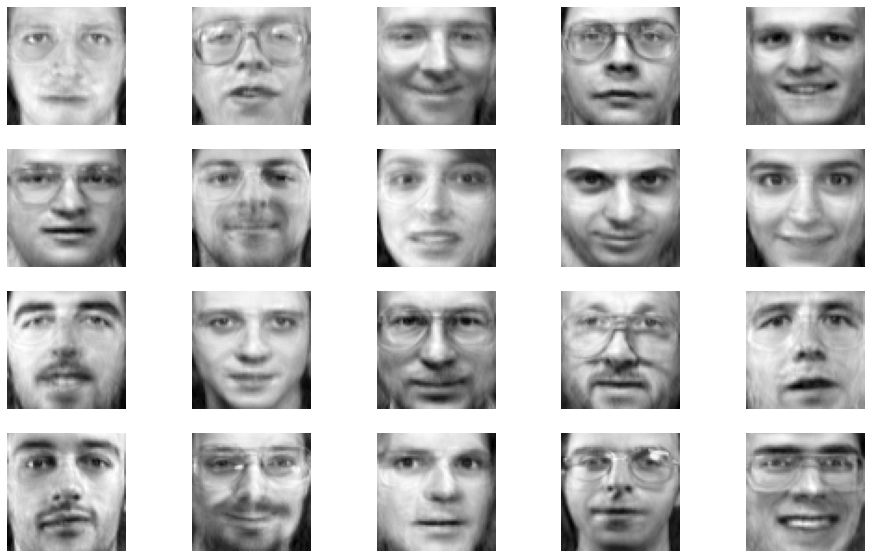

In [8]:
oliv_df_pca = oliv_df_pca[[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190], :]
draw_20(oliv_df_pca)

Jak widać obrazki są lekko skompresowane i w porównaniu do oryginałów są lekko "rozmazane".

Obliczanie błędu rekonstrukcji. Jako ten błąd przyjmuję średni błąd RMSE z wszystkich obrazków.

In [9]:
rmse_all = [0]*20
for i in range(0, 20):
    rmse_all[i] = rmse(x[i], oliv_df_pca[i])
print("Błąd rekonstrukcji: ", sum(rmse_all)/len(rmse_all))

Błąd rekonstrukcji:  0.0012593425490194932


## Modyfikacja obrazków:

### Rotacja 90 stopni:

<Figure size 432x288 with 0 Axes>

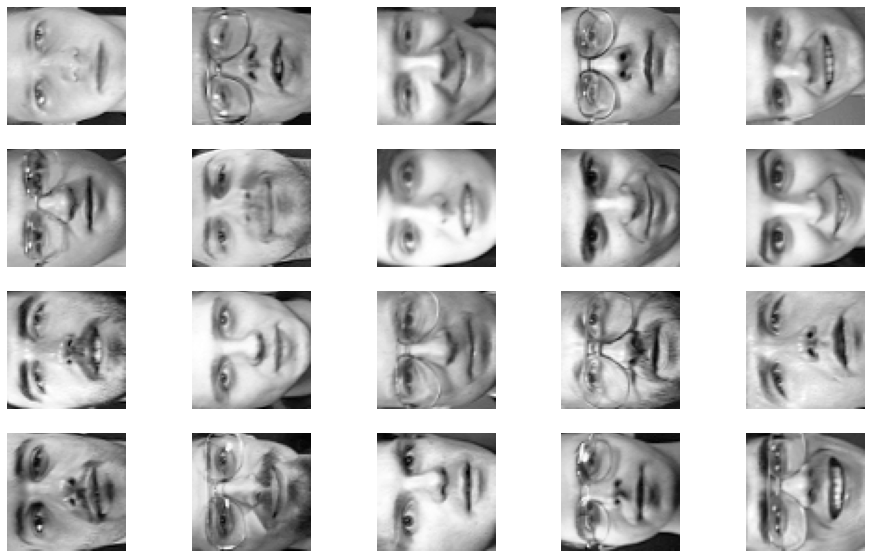

In [10]:
x_rotated = copy.deepcopy(x)
for i in range(0, len(x_rotated)):
    x_rotated[i] = np.rot90(x_rotated[i])
draw_20(x_rotated)

### Przyciemnienie:

<Figure size 432x288 with 0 Axes>

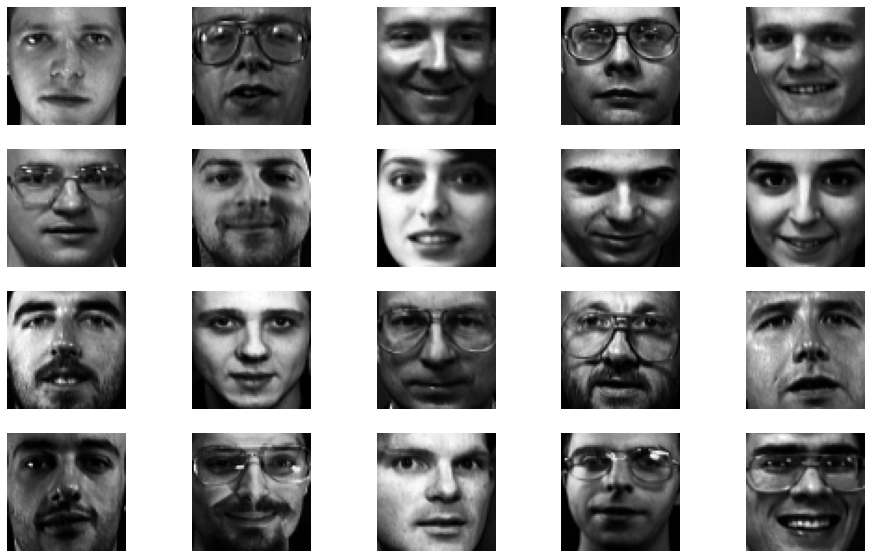

In [11]:
x_dark = copy.deepcopy(x)
for i in range(0, len(x_dark)):
    x_dark[i] = x_dark[i]**(3)
draw_20(x_dark)

### Odbicie w poziomie:

<Figure size 432x288 with 0 Axes>

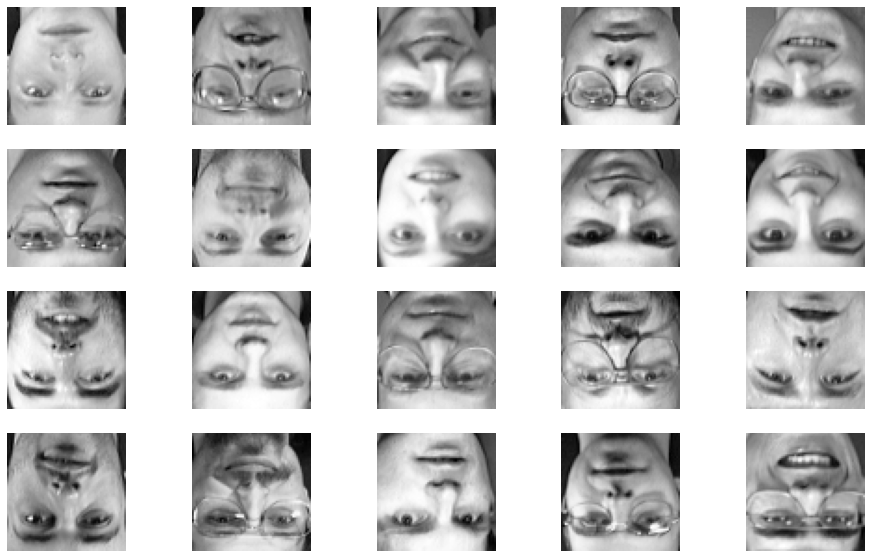

In [12]:
x_flip = copy.deepcopy(x)
for i in range(0, len(x_flip)):
    x_flip[i] = np.flip(x_flip[i], 0)
draw_20(x_flip)

## Transformacja i odwrotna transformacja zmodyfikowanych obrazków:

In [13]:
def transform_and_inverse_20(x):
    x_pca = np.reshape(x, (20, 4096))
    x_pca = pca.transform(x_pca)
    x_pca = pca.inverse_transform(x_pca)
    x_pca = np.reshape(x_pca, (20, 64, 64))
    rmse_all = [0]*20
    for i in range(0, 20):
        rmse_all[i] = rmse(x[i], x_pca[i])
    draw_20(x_pca)
    print("Błąd rekonstrukcji: ", sum(rmse_all)/len(rmse_all))

### Dla rotacji:

<Figure size 432x288 with 0 Axes>

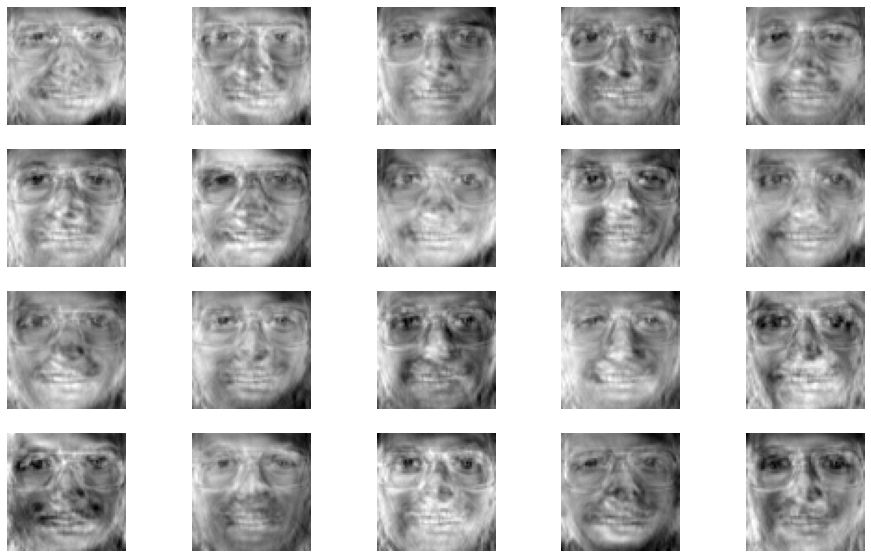

Błąd rekonstrukcji:  0.00979293454438448


In [14]:
transform_and_inverse_20(x_rotated)

### Dla przyciemnienia:

<Figure size 432x288 with 0 Axes>

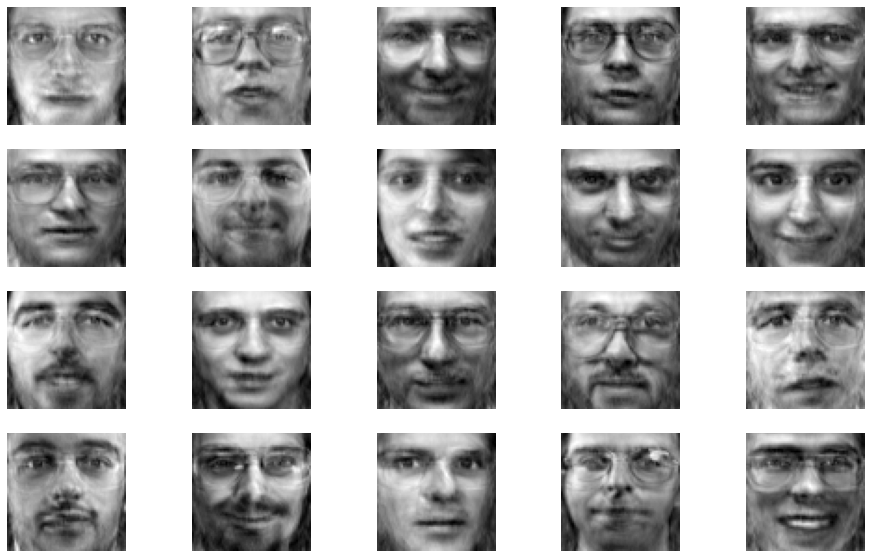

Błąd rekonstrukcji:  0.002216544596012682


In [15]:
transform_and_inverse_20(x_dark)

### Dla odbicia w poziomie:

<Figure size 432x288 with 0 Axes>

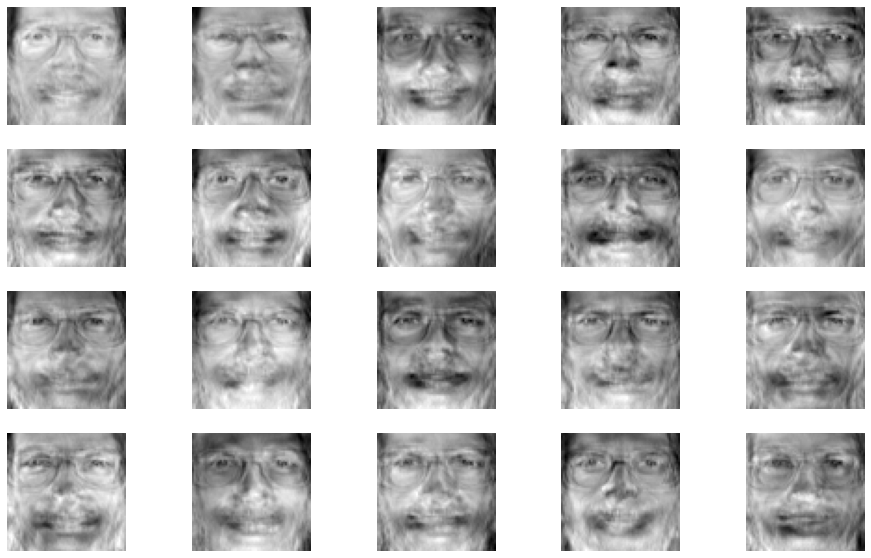

Błąd rekonstrukcji:  0.009606548049487174


In [16]:
transform_and_inverse_20(x_flip)

Jak widać po takiej transformacji przy użyciu PCA wytrenowanego na oryginalych obrazkach zmodyfikowane obrazki "próbują" powrócić do normalnego stanu. Oczywiście są one skompresowane.\
Błędy rekonstrukcji są znacząco większe, prawie 9-krotnie dla rotacji i odbicia oraz 2-krotnie dla przyciemnienia.

## Wykrywanie anomalii
Ponieważ zdjęcia zmodyfikowane zawsze mają wyższy błąd rekonstrukcji, to dzięki temu można wykrywać anomalie. Jeżeli dane zdjęcie będzie miało odstający błąd od reszty, to może to sugerować, że występuje na nim jakaś anomalia, np. jest ono przekrzywione, albo kolory są lekko zmodyfikowane. W ten sposób można wykrywać zarówno anomalie związne z samym zdjęciem jak i związane z fotografowaną osobą. Np. wykrywać, gdy ktoś przekrzywił głowę albo miał nietypowe oświtelnie podczas robienia zdjęcia.